In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from analyzer.model.regression_model import RegressionModel
from data.io import Reader
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from keras.src.layers import Dense
from keras import Sequential, Input
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Постановка задачи
1. Провести анализ и предсказать возраст краба

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA110_CrabAge.csv



# Проверка целостности датасета

In [2]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA110_CrabAge.csv")
df = df_original.copy().reset_index(drop=True)
df['length_diameter_height'] = df['length']*df['diameter']*df['height']
df = df.drop('length', axis=1)
df = df.drop('diameter', axis=1)
df = df.drop('height', axis=1)
df.head(10)

,sex,weight,shucked_weight,viscera_weight,shell_weight,age,length_diameter_height
0,I,13.225042,6.477861,3.019222,3.231843,7,0.210742
1,F,35.025807,12.573003,8.802520,10.347568,14,0.959500
2,M,22.481154,9.723878,5.769123,6.095142,9,0.584375
3,M,22.112610,8.972617,4.791066,6.704657,8,0.468334
4,I,16.371836,6.548735,4.053979,5.017862,9,0.462187
5,I,1.063106,0.510291,0.170097,0.311845,3,0.020566
6,I,4.224075,1.644271,0.921359,1.332426,7,0.080965
7,M,25.868919,11.609120,5.173784,8.193005,9,0.624750
8,I,10.886208,3.898056,1.729319,4.139027,14,0.285547
9,I,18.271253,8.944267,3.529513,5.273007,11,0.369078


In [3]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sex                     3893 non-null   object 
 1   weight                  3893 non-null   float64
 2   shucked_weight          3893 non-null   float64
 3   viscera_weight          3893 non-null   float64
 4   shell_weight            3893 non-null   float64
 5   age                     3893 non-null   int64  
 6   length_diameter_height  3893 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 213.0+ KB


In [4]:
# посмотрим на пропуски в данных
df.isna().sum()

sex                       0
weight                    0
shucked_weight            0
viscera_weight            0
shell_weight              0
age                       0
length_diameter_height    0
dtype: int64

In [5]:
# Посмотрим статистику о датасете
df.describe()

,weight,shucked_weight,viscera_weight,shell_weight,age,length_diameter_height
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,23.567275,10.207342,5.136546,6.795844,9.954791,0.544227
std,13.891201,6.275275,3.104133,3.943392,3.220967,0.330582
min,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000
25%,12.672227,5.343881,2.664853,3.713785,8.000000,0.284625
50%,22.792998,9.539607,4.861939,6.662133,10.000000,0.515625
75%,32.786197,14.273973,7.200773,9.355335,11.000000,0.764285
max,80.101512,42.184056,21.545620,28.491248,29.000000,3.205271


# Оптимизируем датасет

In [6]:
df['age'] = df['age'].astype('uint8')

In [7]:
# проверяем
df.describe()

,weight,shucked_weight,viscera_weight,shell_weight,age,length_diameter_height
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,23.567275,10.207342,5.136546,6.795844,9.954791,0.544227
std,13.891201,6.275275,3.104133,3.943392,3.220967,0.330582
min,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000
25%,12.672227,5.343881,2.664853,3.713785,8.000000,0.284625
50%,22.792998,9.539607,4.861939,6.662133,10.000000,0.515625
75%,32.786197,14.273973,7.200773,9.355335,11.000000,0.764285
max,80.101512,42.184056,21.545620,28.491248,29.000000,3.205271


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sex                     3893 non-null   object 
 1   weight                  3893 non-null   float64
 2   shucked_weight          3893 non-null   float64
 3   viscera_weight          3893 non-null   float64
 4   shell_weight            3893 non-null   float64
 5   age                     3893 non-null   uint8  
 6   length_diameter_height  3893 non-null   float64
dtypes: float64(5), object(1), uint8(1)
memory usage: 186.4+ KB


# Проводим первичный визуальный анализ зависимостей данных

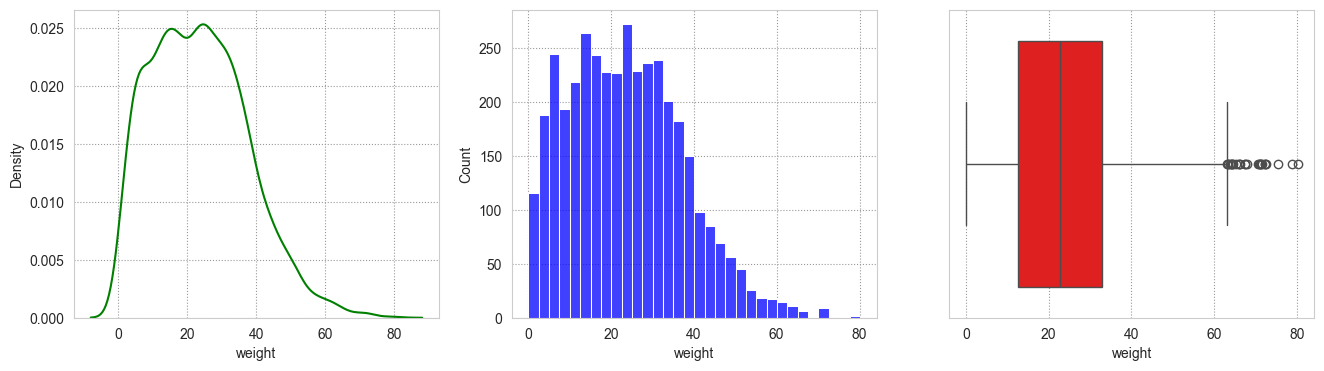

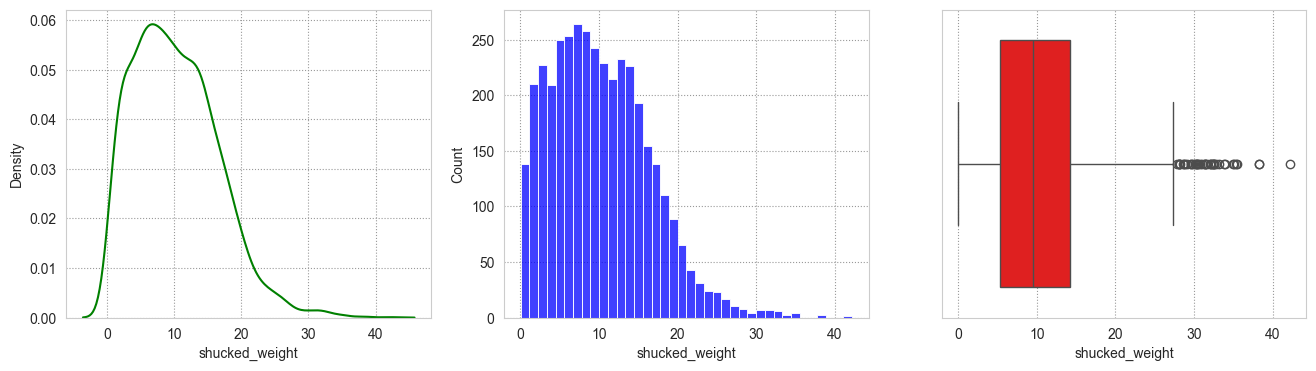

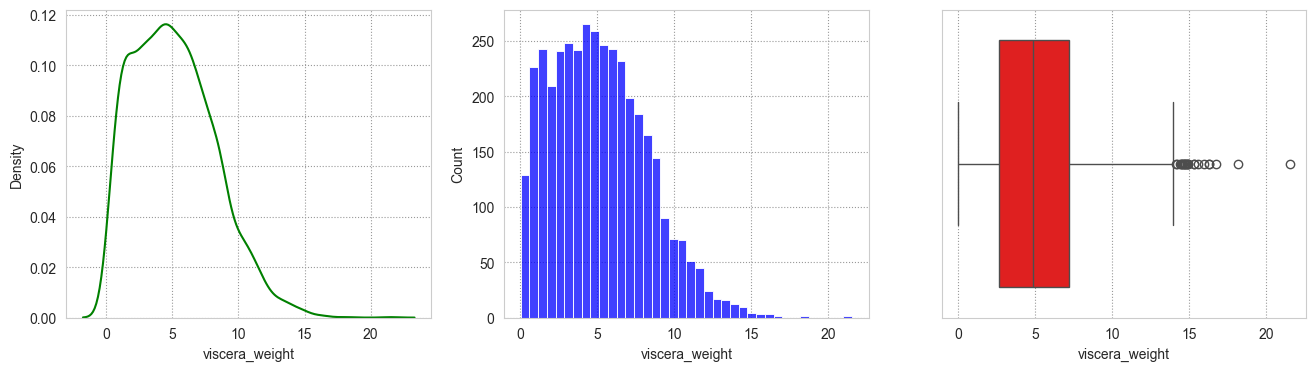

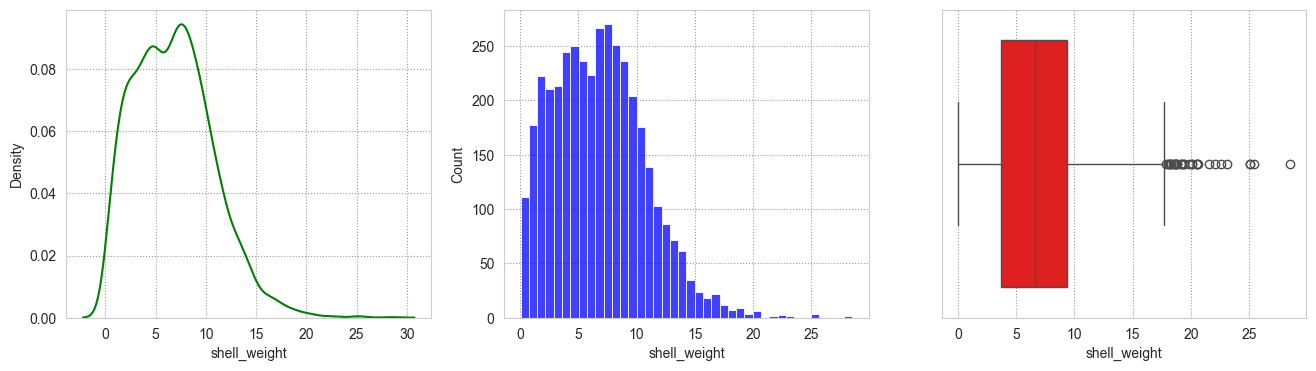

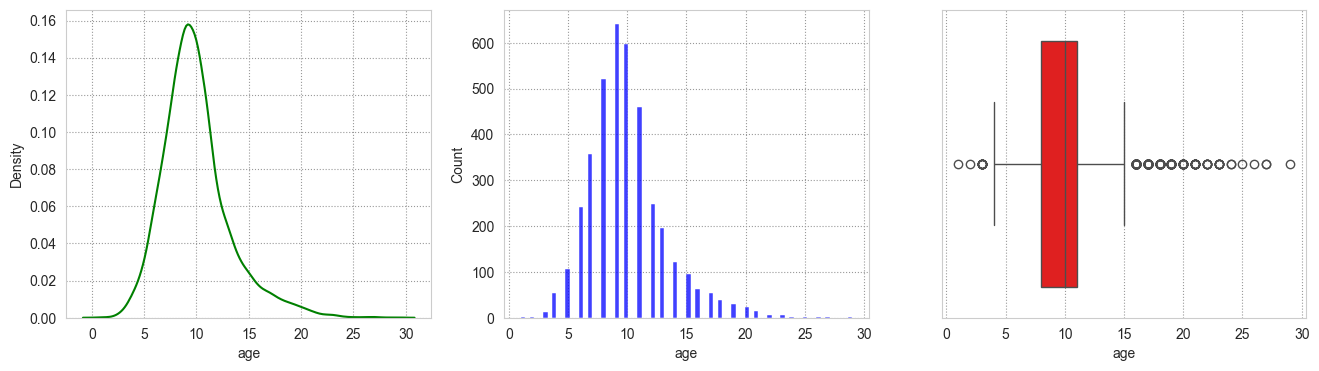

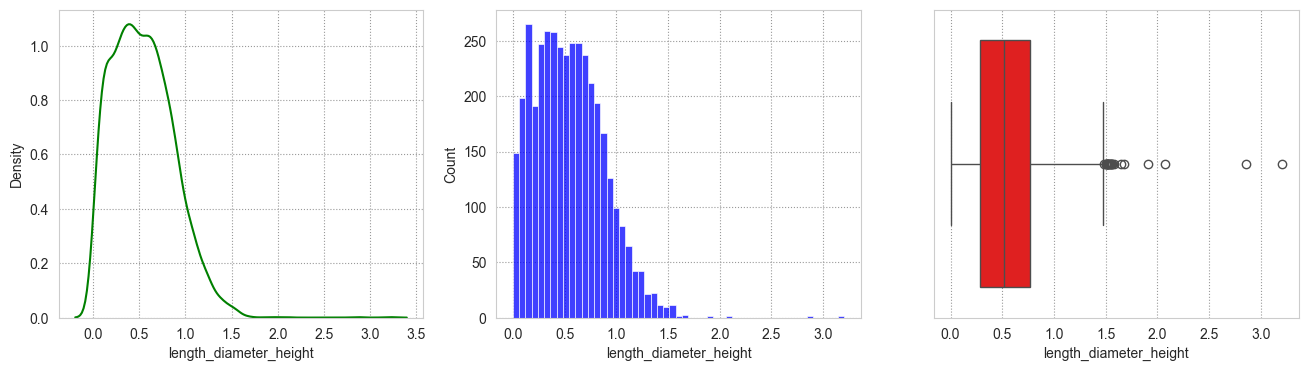

In [9]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

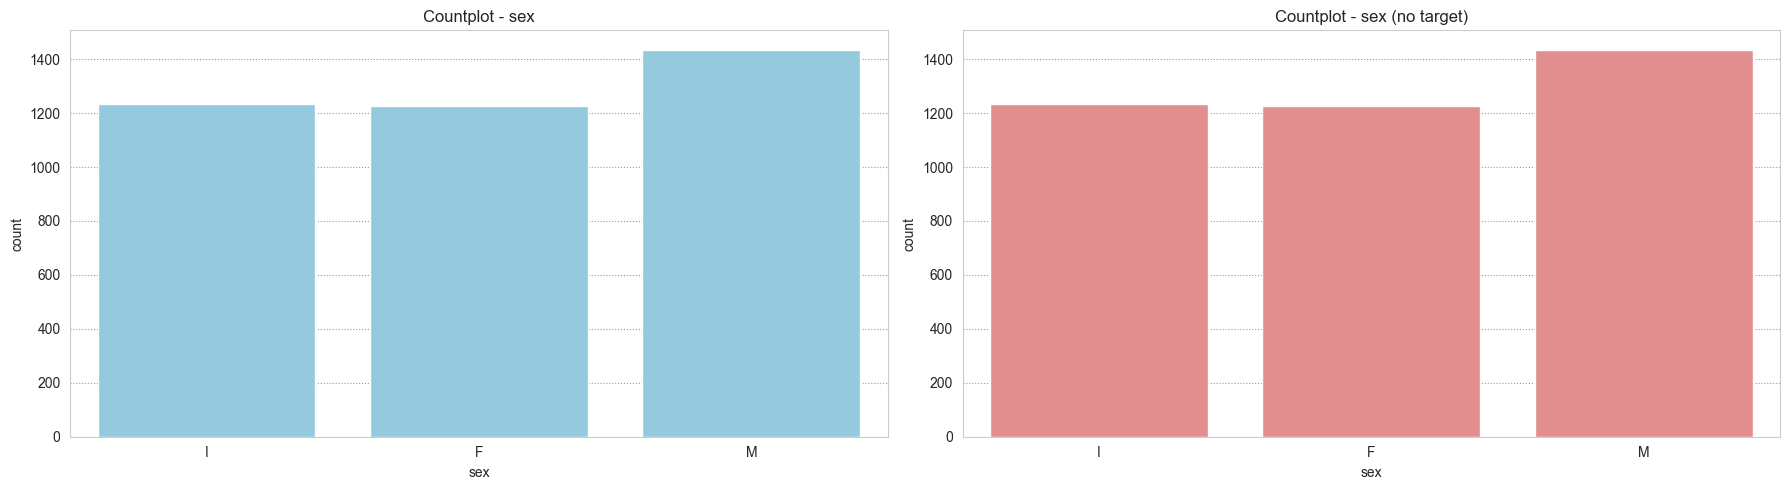

In [10]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

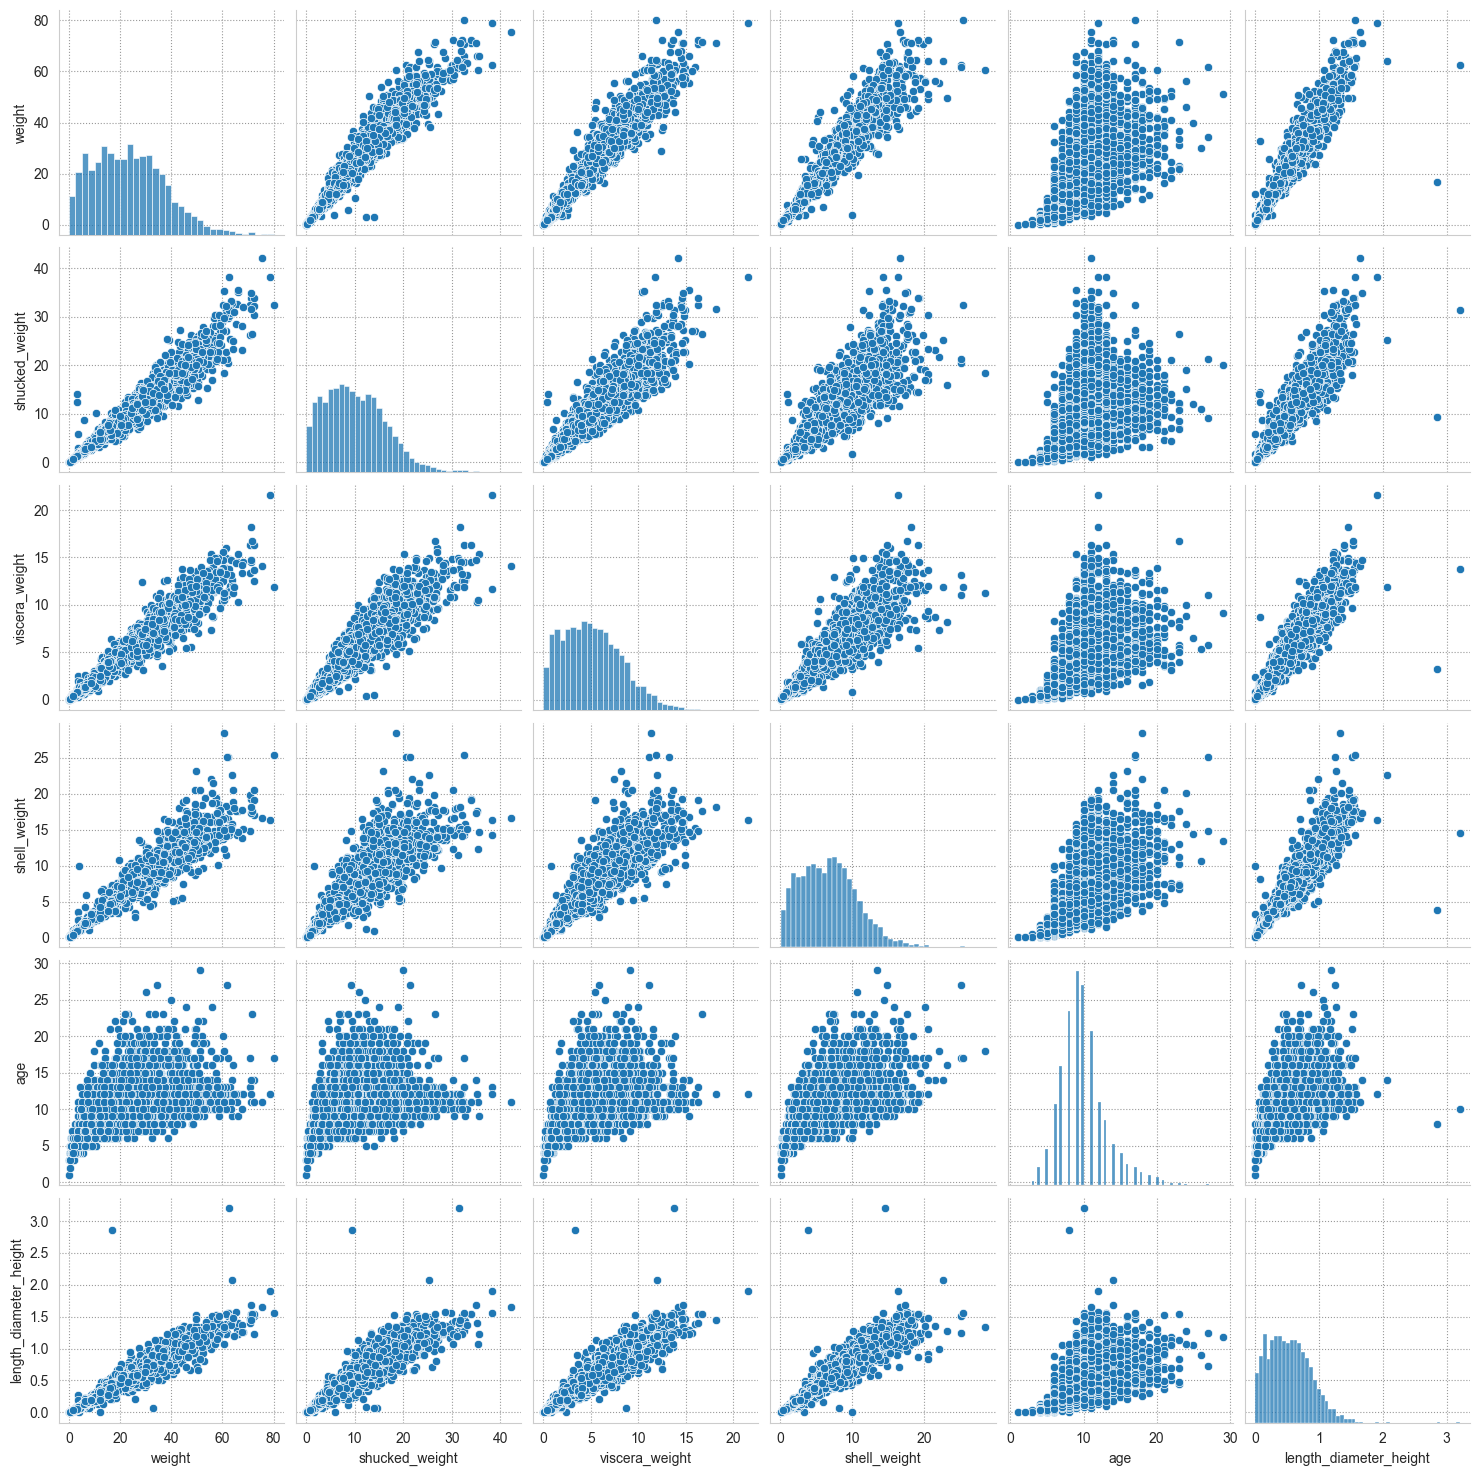

In [11]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

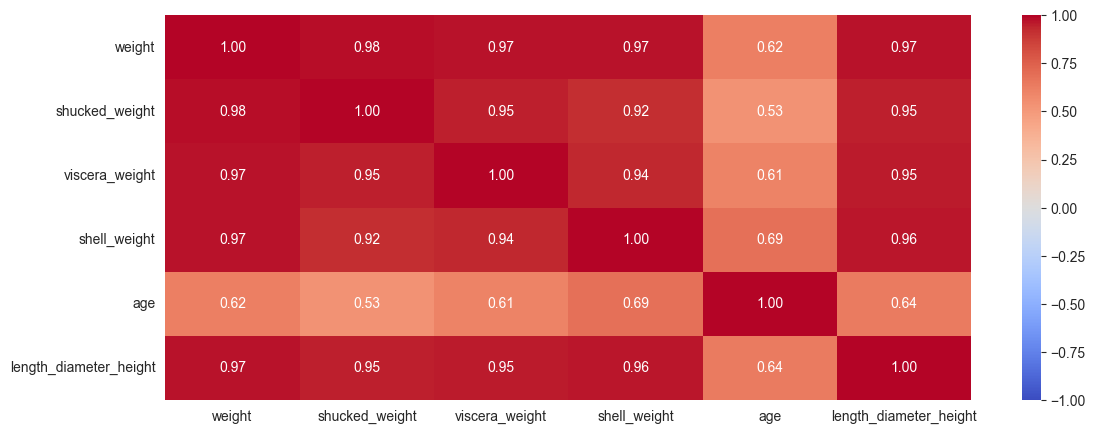

In [12]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [13]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"\n{column} и age:")
    groups = [df[column], df['age']]
    StatCriteria().mannwhitneyu(groups)


weight и age:
Mann-Whitney U test
U_statistic = 12231347.000
Распределения двух выборок не равны (p-value = 0.000).

shucked_weight и age:
Mann-Whitney U test
U_statistic = 7381227.000
Распределения двух выборок не равны (p-value = 0.047).

viscera_weight и age:
Mann-Whitney U test
U_statistic = 2016158.000
Распределения двух выборок не равны (p-value = 0.000).

shell_weight и age:
Mann-Whitney U test
U_statistic = 3959715.000
Распределения двух выборок не равны (p-value = 0.000).

age и age:
Mann-Whitney U test
U_statistic = 7577724.500
Распределения двух выборок равны (p-value = 1.000).

length_diameter_height и age:
Mann-Whitney U test
U_statistic = 374.000
Распределения двух выборок не равны (p-value = 0.000).


In [14]:
# проверяем распределения между таргетом и уник зн-ями катег признаков
column_list = ['sex']
for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['age'])
    StatCriteria().kruskal(groups)

kruskal
statistic = 1013.624
Медианы всех групп не равны (p-value = 0.000).


In [15]:
# Проверим допущение о мультиколлинеарности признаков
exclude_features = ['age', 'viscera_weight','shucked_weight', 'weight']
# exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height']
# exclude_features = ['age', 'weight', 'diameter']
StatCriteria().VIF(df, exclude_features)

,VIF
shell_weight,30.554082
length_diameter_height,30.554082


## стат.обработка категориальных данных

In [16]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,sex
count,3893
unique,3
top,M
freq,1435


# Подготавливаем данные

In [17]:
df.columns

Index(['sex', 'weight', 'shucked_weight', 'viscera_weight', 'shell_weight',
       'age', 'length_diameter_height'],
      dtype='object')

In [18]:
# разделяем данные
target = ['age']
# exclude_features = ['age']
exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight']
# exclude_features = ['age', 'length', 'height', 'weight', 'viscera_weight']  # по Lasso: 'length', 'height', 'weight', 'viscera_weight'
# exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height']  ## по VIF: 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height'
# exclude_features = ['age', 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter']  ## по VIF: 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter'
# exclude_features = ['age', 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter', 'height']  ## по VIF: 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter'
# exclude_features = ['age','length', 'diameter', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight', 'sex']  

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

# X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)
X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().StandardScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# pca = PCA(n_components=0.95)
# X_train = pd.DataFrame(pca.fit_transform(X_train))
# X_test = pd.DataFrame(pca.transform(X_test))

In [19]:
# Применим метод Lasso для оценки признаков
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Lasso-регрессии:
                  Feature  Coefficient
0                     sex     0.684663
1                  weight     0.096427
2  length_diameter_height     1.220274
R²: 0.339
MAE: 1.97
MAPE: 0%
RMSE: 3
MSE: 8


In [20]:
# Трансформируем Х в полиномиальные признаки
# X_train, X_test, y_train, y_test = RegressionModel().PolynomialFeatures(X_train, X_test, y_train, y_test, include_bias=False)

# Находим модель

In [21]:
y_test, y_pred, _ = RegressionModel().Ridge(X_train, X_test, y_train, y_test, alpha=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Ridge-регрессии:
                  Feature  Coefficient
0                     sex     0.691144
1                  weight     0.096698
2  length_diameter_height     1.226494
R²: 0.339
MAE: 1.97
MAPE: 0%
RMSE: 3
MSE: 8


In [22]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.333
MAE: 1.78
MAPE: 0%
RMSE: 3
MSE: 8


In [23]:
y_test, y_pred, _ = RegressionModel().RandomForestRegressor(X_train, X_test, y_train, y_test,
                                                            max_depth=5,
                                                            min_samples_split=4,
                                                            min_samples_leaf=2,
                                                            n_estimators=100)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.384
MAE: 1.87
MAPE: 0%
RMSE: 3
MSE: 7


In [24]:
y_test, y_pred, _ = RegressionModel().GradientBoostingRegressor(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.368
MAE: 1.89
MAPE: 0%
RMSE: 3
MSE: 7


In [25]:
# Применим метод байесовской линейной регрессии
y_test, y_pred, _ = RegressionModel().BayesianRidge(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

Коэффициенты Байесовской регрессии:
                  Feature  Coefficient
0                     sex     0.688382
1                  weight     0.154599
2  length_diameter_height     1.167702
R²: 0.340
MAE: 1.97
MAPE: 0%
RMSE: 3
MSE: 8


Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: -5.9542 - loss: 67.1262 - val_R2Score: 0.0883 - val_loss: 10.4947
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.3921 - loss: 14.4408 - val_R2Score: 0.1658 - val_loss: 9.6044
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.2718 - loss: 13.4744 - val_R2Score: 0.2606 - val_loss: 8.5179
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.1306 - loss: 10.9489 - val_R2Score: 0.2339 - val_loss: 8.8192
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.1179 - loss: 11.3282 - val_R2Score: 0.2885 - val_loss: 8.1915
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.0810 - loss: 10.5813 - val_R2Score: 0.2879 - val_loss: 8.1960
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.0717 - loss: 10.4064 - val_R2Score: 0.3106 - val_loss: 7.9337
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.0896 - loss: 11.3061 - val_R2Score: 0

<Axes: >

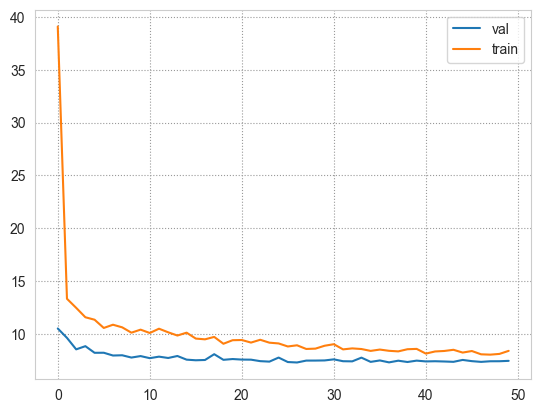

In [26]:
from keras.src.layers import Dropout
from keras.src.regularizers import regularizers
from keras.src.optimizers import Adam

# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) 

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['R2Score'])

# Обучение модели
epochs = 50
batch_size=16
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')